🔍 Analyzing group image: /kaggle/input/znz-cloves/group_photos/grade1/20250821_102651.jpg
✅ Resized image to 800x800 for memory-efficient processing
✅ Detected 412 individual cloves

📋 OFFICIAL GRADING RULES CHECK:
--------------------------------------------------
Total cloves detected: 412
Mpeta (Grade 4) count: 272 (66.0%)

✅ INFERRED BATCH GRADE: Grade 4
📘 Rule justification:
   • Max allowed Mpeta: ≤100%
   • Observed Mpeta: 66.0% → ✅ Compliant
   • Expected color: fermented (khoker)
   • May contain headless cloves (allowed in Grade 3+)


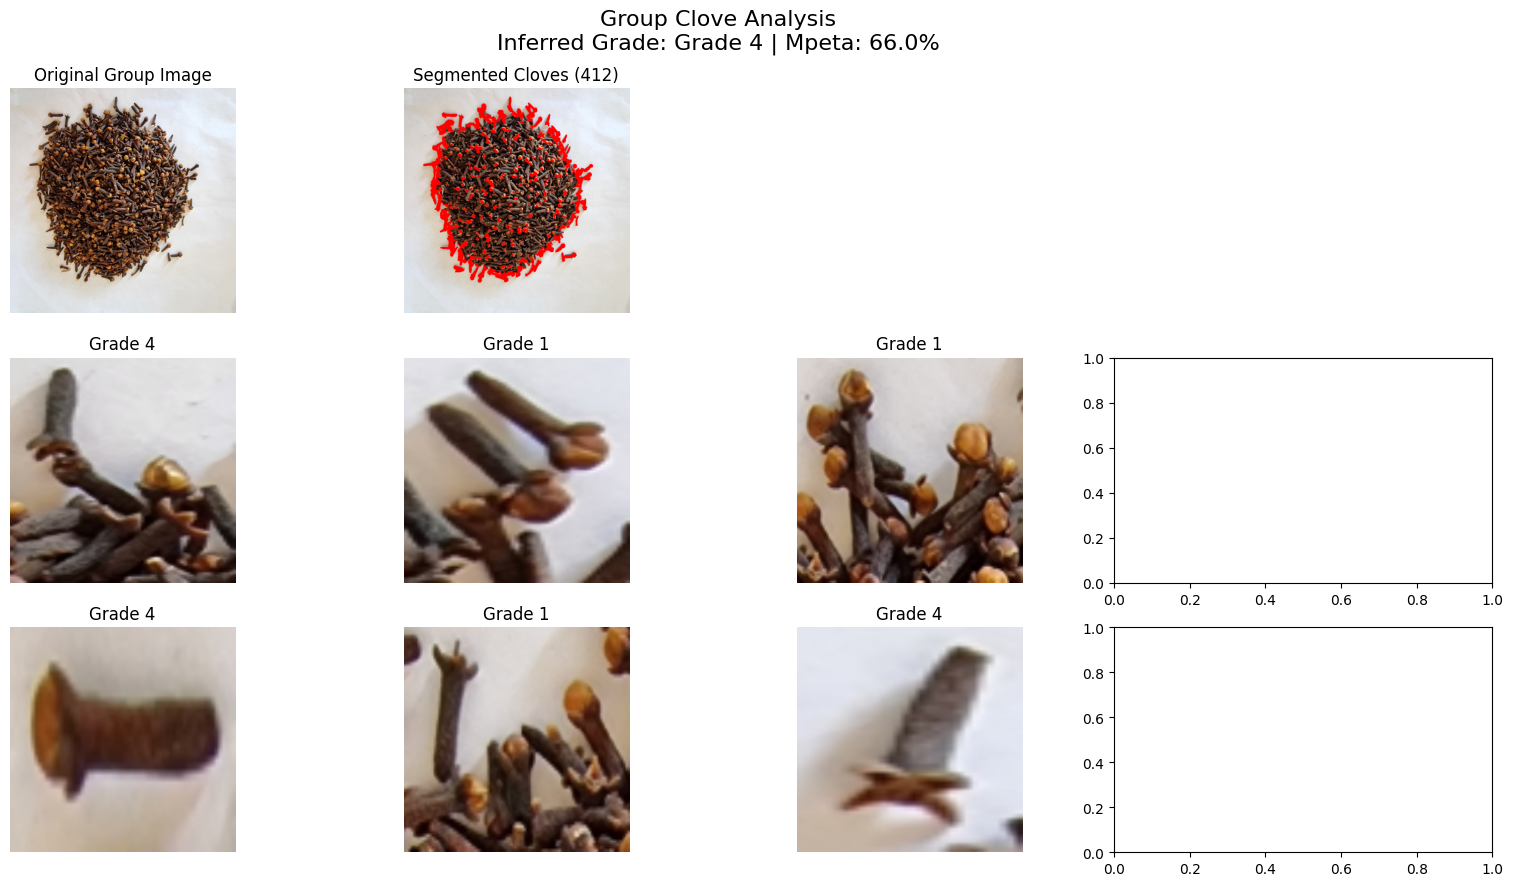


📝 AUDIT TRAIL SUMMARY:
------------------------------
  Grade 1: 140 cloves (34.0%)
  Grade 2: 0 cloves (0.0%)
  Grade 3: 0 cloves (0.0%)
  Grade 4: 272 cloves (66.0%)

🎯 Conclusion: Batch complies with **Grade 4** per ZSTC Mpeta threshold.
🔍 Analyzing group image: /kaggle/input/znz-cloves/group_photos/grade2/20250821_105052.jpg
✅ Resized image to 800x800 for memory-efficient processing
✅ Detected 296 individual cloves

📋 OFFICIAL GRADING RULES CHECK:
--------------------------------------------------
Total cloves detected: 296
Mpeta (Grade 4) count: 203 (68.6%)

✅ INFERRED BATCH GRADE: Grade 4
📘 Rule justification:
   • Max allowed Mpeta: ≤100%
   • Observed Mpeta: 68.6% → ✅ Compliant
   • Expected color: fermented (khoker)
   • May contain headless cloves (allowed in Grade 3+)


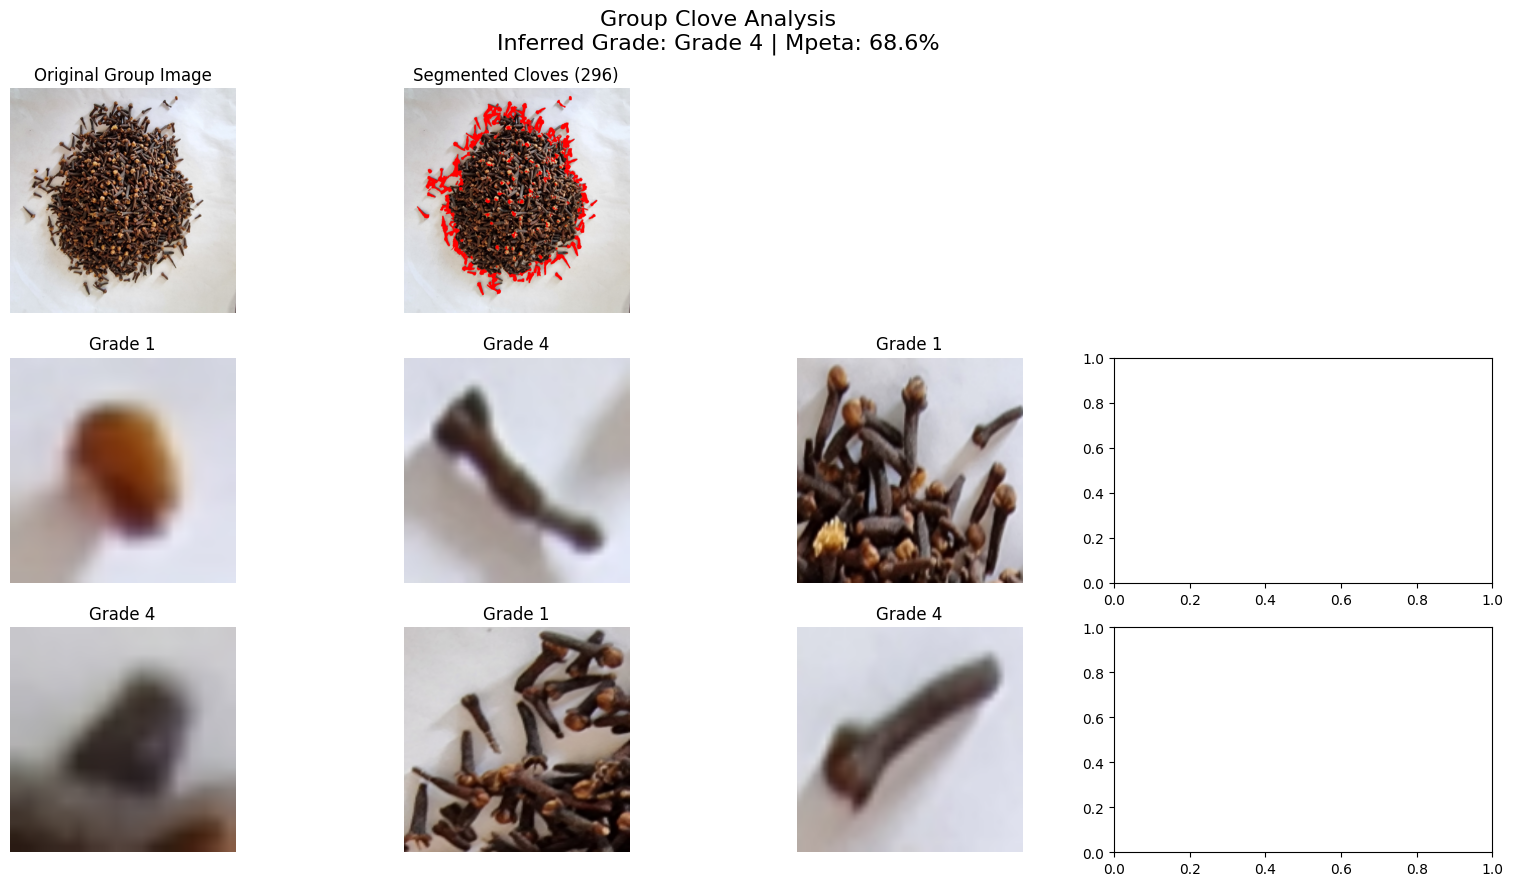


📝 AUDIT TRAIL SUMMARY:
------------------------------
  Grade 1: 93 cloves (31.4%)
  Grade 2: 0 cloves (0.0%)
  Grade 3: 0 cloves (0.0%)
  Grade 4: 203 cloves (68.6%)

🎯 Conclusion: Batch complies with **Grade 4** per ZSTC Mpeta threshold.
🔍 Analyzing group image: /kaggle/input/znz-cloves/group_photos/grade3/20250822_111823.jpg
✅ Resized image to 800x800 for memory-efficient processing
✅ Detected 319 individual cloves

📋 OFFICIAL GRADING RULES CHECK:
--------------------------------------------------
Total cloves detected: 319
Mpeta (Grade 4) count: 289 (90.6%)

✅ INFERRED BATCH GRADE: Grade 4
📘 Rule justification:
   • Max allowed Mpeta: ≤100%
   • Observed Mpeta: 90.6% → ✅ Compliant
   • Expected color: fermented (khoker)
   • May contain headless cloves (allowed in Grade 3+)


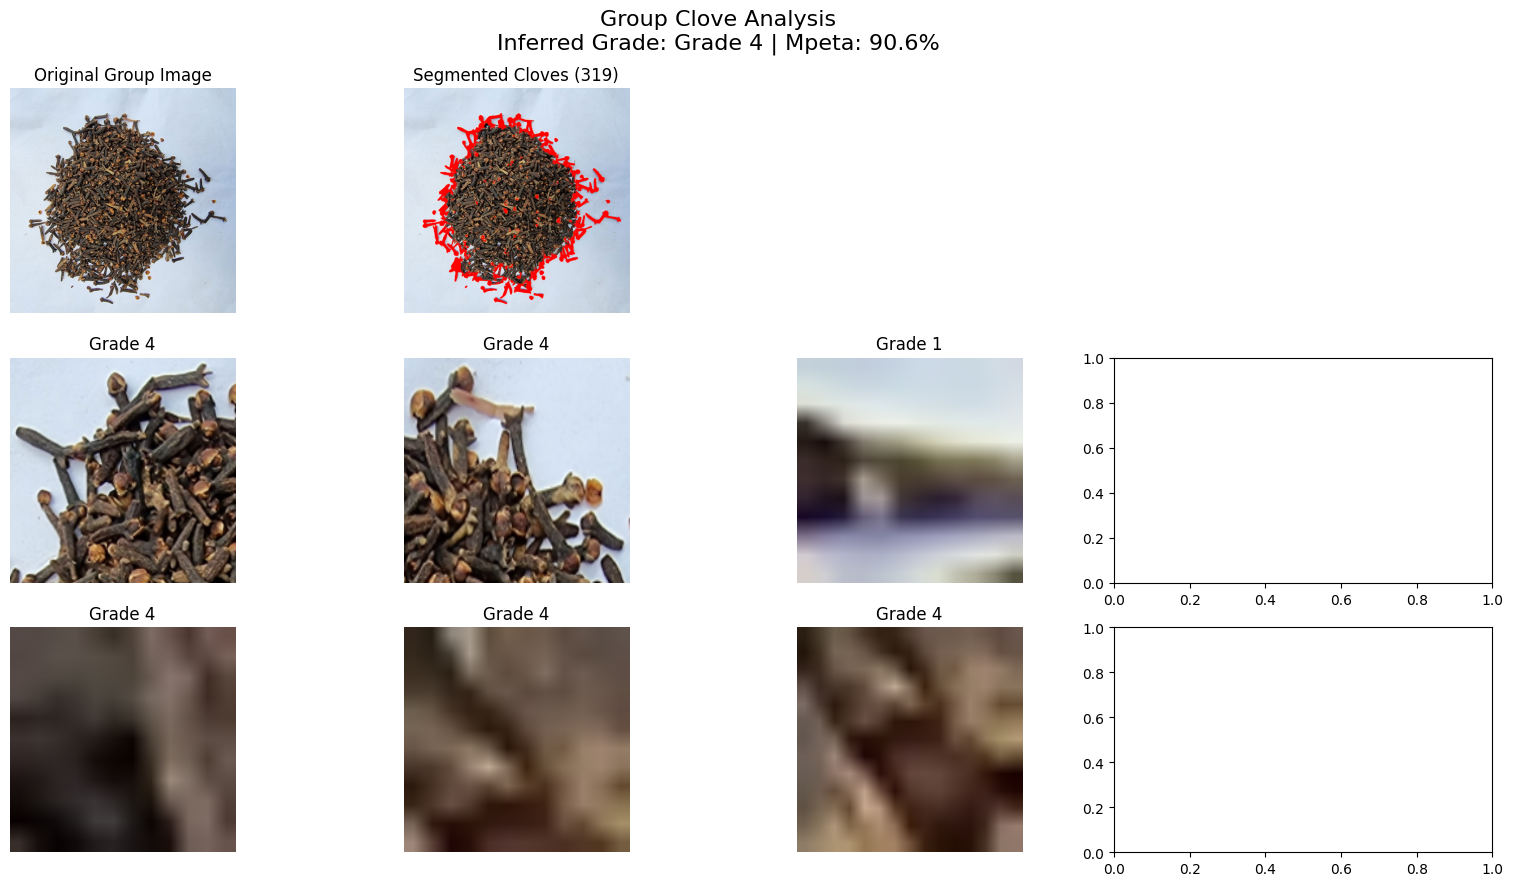


📝 AUDIT TRAIL SUMMARY:
------------------------------
  Grade 1: 30 cloves (9.4%)
  Grade 2: 0 cloves (0.0%)
  Grade 3: 0 cloves (0.0%)
  Grade 4: 289 cloves (90.6%)

🎯 Conclusion: Batch complies with **Grade 4** per ZSTC Mpeta threshold.
🔍 Analyzing group image: /kaggle/input/znz-cloves/group_photos/grade4/20250820_100336.jpg
✅ Resized image to 800x800 for memory-efficient processing
✅ Detected 451 individual cloves

📋 OFFICIAL GRADING RULES CHECK:
--------------------------------------------------
Total cloves detected: 451
Mpeta (Grade 4) count: 179 (39.7%)

✅ INFERRED BATCH GRADE: Grade 4
📘 Rule justification:
   • Max allowed Mpeta: ≤100%
   • Observed Mpeta: 39.7% → ✅ Compliant
   • Expected color: fermented (khoker)
   • May contain headless cloves (allowed in Grade 3+)


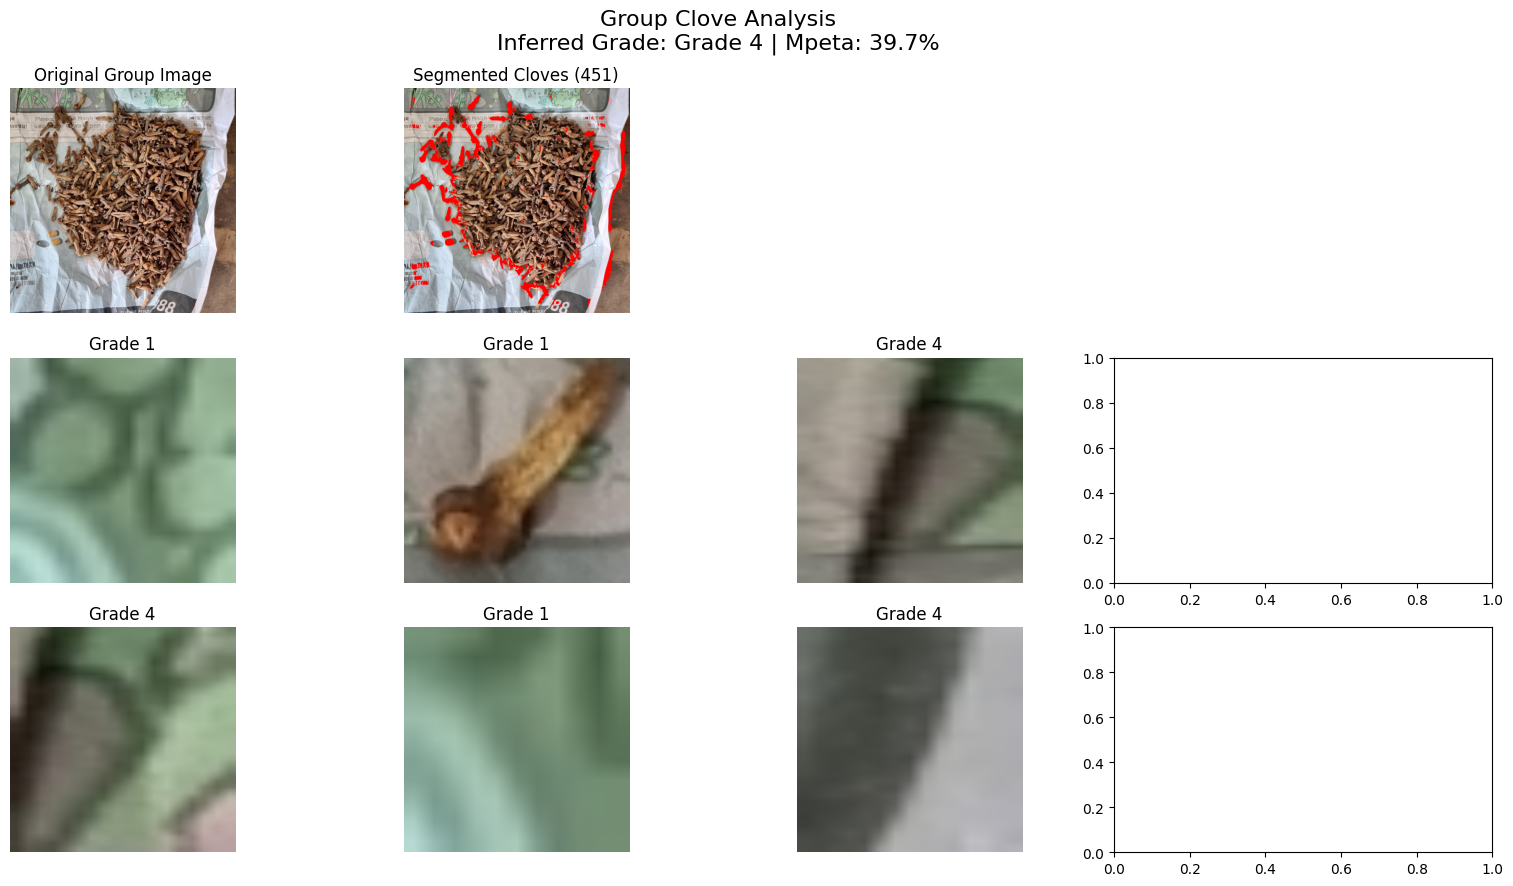


📝 AUDIT TRAIL SUMMARY:
------------------------------
  Grade 1: 272 cloves (60.3%)
  Grade 2: 0 cloves (0.0%)
  Grade 3: 0 cloves (0.0%)
  Grade 4: 179 cloves (39.7%)

🎯 Conclusion: Batch complies with **Grade 4** per ZSTC Mpeta threshold.


In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

# ----------------------------
# LOAD MODELS (adjust if using different architecture)
# ----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==================== DEFINE ENHANCED UNET (REQUIRED FOR LOADING SEGMENTATION MODEL) ====================
class EnhancedUNet(nn.Module):
    """Enhanced U-Net with modern features for better segmentation"""
    def __init__(self, in_channels=3, out_channels=1, features=None):
        super(EnhancedUNet, self).__init__()
        if features is None:
            features = [64, 128, 256, 512]
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Down part of UNET with residual connections
        in_ch = in_channels
        for feature in features:
            self.downs.append(EnhancedDoubleConv(in_ch, feature))
            in_ch = feature
        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(EnhancedDoubleConv(feature*2, feature))
        self.bottleneck = EnhancedDoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        self.dropout = nn.Dropout2d(0.2)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        x = self.dropout(x)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = nn.functional.interpolate(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        return torch.sigmoid(self.final_conv(x))

class EnhancedDoubleConv(nn.Module):
    """Enhanced double convolution with batch norm and residual connection"""
    def __init__(self, in_channels, out_channels):
        super(EnhancedDoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        self.relu = nn.ReLU(inplace=True)
        # Residual connection
        if in_channels != out_channels:
            self.residual = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        else:
            self.residual = nn.Identity()

    def forward(self, x):
        residual = self.residual(x)
        out = self.conv(x)
        out += residual
        return self.relu(out)

# Load segmentation model
seg_model = EnhancedUNet(in_channels=3, out_channels=1).to(device)
seg_checkpoint = torch.load("/kaggle/input/segmentation-model/pytorch/default/1/best_segmentation_model.pth", map_location=device)
seg_model.load_state_dict(seg_checkpoint['model_state_dict'])
seg_model.eval()

# Load classification model
class ContextAwareClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        from torchvision import models
        self.backbone = models.resnet18(weights=None)
        # Modify first layer for 4 channels (RGB + mask)
        old_conv = self.backbone.conv1
        self.backbone.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        with torch.no_grad():
            self.backbone.conv1.weight[:, :3] = old_conv.weight
            self.backbone.conv1.weight[:, 3:4] = old_conv.weight.mean(dim=1, keepdim=True)
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.backbone.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.backbone(x)

cls_model = ContextAwareClassifier(num_classes=4).to(device)
cls_model.load_state_dict(torch.load("/kaggle/input/context-aware-model/pytorch/default/1/best_context_aware_model.pth", map_location=device))
cls_model.eval()

# Preprocessing — IMPORTANT: 4-channel normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406, 0.0],   # mask channel mean ≈ 0 (since binary 0/1)
        std=[0.229, 0.224, 0.225, 1.0]      # mask std = 1 (or 0.5 if scaled to [0,1])
    )
])

grade_names = ["Grade 1", "Grade 2", "Grade 3", "Grade 4"]
grade_rules = {
    "Grade 1": {"max_mpeta_pct": 3, "color": "golden/saffron", "head_required": True},
    "Grade 2": {"max_mpeta_pct": 7, "color": "slightly blackish/faded", "head_required": True},
    "Grade 3": {"max_mpeta_pct": 20, "color": "faded", "head_required": False},
    "Grade 4": {"max_mpeta_pct": 100, "color": "fermented (khoker)", "head_required": False}
}

# ==================== ANALYZE GROUP IMAGE FUNCTION ====================
def analyze_group_image(image_path):
    print(f"🔍 Analyzing group image: {image_path}")
    
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found!")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]

    # ⬇️ RESIZE FOR MEMORY EFFICIENCY ⬇️
    max_dim = 800  # Adjust based on your GPU (try 600 if still OOM)
    if max(h, w) > max_dim:
        scale = max_dim / max(h, w)
        new_h, new_w = int(h * scale), int(w * scale)
        image_rgb = cv2.resize(image_rgb, (new_w, new_h), interpolation=cv2.INTER_AREA)
        print(f"✅ Resized image to {new_w}x{new_h} for memory-efficient processing")

    # Step 1: Segment all cloves using U-Net
    input_tensor = torch.tensor(image_rgb).permute(2,0,1).unsqueeze(0).float().to(device) / 255.0
    with torch.no_grad():
        seg_mask = seg_model(input_tensor)[0, 0].cpu().numpy()
    
    # Binarize and label connected components
    binary_mask = (seg_mask > 0.5).astype(np.uint8)
    num_labels, labels_im = cv2.connectedComponents(binary_mask)

    if num_labels <= 1:
        print("⚠️ No cloves detected!")
        return

    print(f"✅ Detected {num_labels - 1} individual cloves")

    # Step 2: Extract each clove and classify
    predictions = []
    clove_patches = []

    for label_id in range(1, num_labels):
        # Create instance mask
        instance_mask = (labels_im == label_id).astype(np.uint8)
        
        # Get bounding box
        coords = cv2.findNonZero(instance_mask)
        if coords is None:
            continue
        x, y, w_box, h_box = cv2.boundingRect(coords)
        margin = 5
        x1 = max(0, x - margin)
        y1 = max(0, y - margin)
        x2 = min(image_rgb.shape[1], x + w_box + margin)
        y2 = min(image_rgb.shape[0], y + h_box + margin)

        # Crop image and mask
        cropped_img = image_rgb[y1:y2, x1:x2]  # [H, W, 3], uint8
        cropped_mask = instance_mask[y1:y2, x1:x2]  # [H, W], binary 0/1
        
        # Resize to 224x224
        cropped_img = cv2.resize(cropped_img, (224, 224))
        cropped_mask = cv2.resize(cropped_mask, (224, 224), interpolation=cv2.INTER_NEAREST)
        
        # Combine into 4-channel uint8 image (RGBA)
        mask_uint8 = (cropped_mask * 255).astype(np.uint8)
        combined = np.concatenate([cropped_img, mask_uint8[..., None]], axis=2)  # [224, 224, 4]
        combined_pil = Image.fromarray(combined)  # Pillow auto-detects 4-channel as RGBA
        
        # Transform
        input_cls = transform(combined_pil).unsqueeze(0).to(device)

        # Classify
        with torch.no_grad():
            logits = cls_model(input_cls)
            pred = torch.argmax(logits, dim=1).item()
        
        predictions.append(pred)
        clove_patches.append(cropped_img)

    # Step 3: Count grades
    total = len(predictions)
    counts = Counter(predictions)
    grade_counts = [counts[i] for i in range(4)]
    mpeta_count = grade_counts[3]
    mpeta_pct = (mpeta_count / total) * 100 if total > 0 else 0

    # Step 4: Apply official grading logic
    print("\n📋 OFFICIAL GRADING RULES CHECK:")
    print("-" * 50)
    print(f"Total cloves detected: {total}")
    print(f"Mpeta (Grade 4) count: {mpeta_count} ({mpeta_pct:.1f}%)")
    
    # Determine highest possible grade based on Mpeta %
    inferred_grade = "Grade 4"
    if mpeta_pct <= 3:
        inferred_grade = "Grade 1"
    elif mpeta_pct <= 7:
        inferred_grade = "Grade 2"
    elif mpeta_pct <= 20:
        inferred_grade = "Grade 3"

    # Explain using rules
    rule = grade_rules[inferred_grade]
    print(f"\n✅ INFERRED BATCH GRADE: {inferred_grade}")
    print(f"📘 Rule justification:")
    print(f"   • Max allowed Mpeta: ≤{rule['max_mpeta_pct']}%")
    print(f"   • Observed Mpeta: {mpeta_pct:.1f}% → {'✅ Compliant' if mpeta_pct <= rule['max_mpeta_pct'] else '❌ Non-compliant'}")
    print(f"   • Expected color: {rule['color']}")
    if not rule['head_required']:
        print(f"   • May contain headless cloves (allowed in Grade 3+)")
    
    # Additional note for Grade 1/2
    if inferred_grade in ["Grade 1", "Grade 2"]:
        print(f"   • Must be well-dried, <5% foreign matter, and mostly headed")
        print(f"   • (Note: Full validation requires moisture & foreign matter analysis)")

    # Step 5: Visualization
    fig, axes = plt.subplots(3, 4, figsize=(16, 9))
    fig.suptitle(f"Group Clove Analysis\nInferred Grade: {inferred_grade} | Mpeta: {mpeta_pct:.1f}%", fontsize=16)

    # Original image
    axes[0, 0].imshow(image_rgb)
    axes[0, 0].set_title("Original Group Image")
    axes[0, 0].axis('off')

    # Segmentation overlay
    overlay = image_rgb.copy()
    overlay[binary_mask == 1] = [255, 0, 0]
    axes[0, 1].imshow(overlay)
    axes[0, 1].set_title(f"Segmented Cloves ({total})")
    axes[0, 1].axis('off')

    # Hide unused top-right plots
    for j in [2, 3]:
        axes[0, j].axis('off')

    # Display up to 6 classified cloves
    for i in range(min(6, len(clove_patches))):
        row = 1 + (i // 3)
        col = i % 3
        ax = axes[row, col]
        ax.imshow(clove_patches[i])
        ax.set_title(f"{grade_names[predictions[i]]}")
        ax.axis('off')

    # Hide remaining slots
    for i in range(len(clove_patches), 6):
        row = 1 + (i // 3)
        col = i % 3
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()
    
    # Final audit summary
    print("\n📝 AUDIT TRAIL SUMMARY:")
    print("-" * 30)
    for i, name in enumerate(grade_names):
        pct = (grade_counts[i] / total * 100) if total > 0 else 0
        print(f"  {name}: {grade_counts[i]} cloves ({pct:.1f}%)")
    print(f"\n🎯 Conclusion: Batch complies with **{inferred_grade}** per ZSTC Mpeta threshold.")

    # Return results for logging
    return {
        'image_path': image_path,
        'total_cloves': total,
        'grade_counts': grade_counts,
        'mpeta_pct': mpeta_pct,
        'inferred_grade': inferred_grade,
        'predictions': predictions  # to log per-clove predictions
    }
# ----------------------------
# EXAMPLE USAGE — CHANGE THIS TO YOUR GROUP PHOTO
# ----------------------------
# test_image = "/kaggle/input/znz-cloves/group_photos/grade1/20250821_102706.jpg"
# analyze_group_image(test_image)

group_photos = [
    "/kaggle/input/znz-cloves/group_photos/grade1/20250821_102651.jpg",
    "/kaggle/input/znz-cloves/group_photos/grade2/20250821_105052.jpg",
    "/kaggle/input/znz-cloves/group_photos/grade3/20250822_111823.jpg",
    "/kaggle/input/znz-cloves/group_photos/grade4/20250820_100336.jpg"
]

for img_path in group_photos:
    print("="*80)
    analyze_group_image(img_path)
    print("="*80)

🔍 Analyzing group image: /kaggle/input/znz-cloves/group_photos/grade1/20250821_102651.jpg
✅ Resized image to 800x800 for memory-efficient processing
✅ Detected 412 individual cloves

📋 OFFICIAL GRADING RULES CHECK:
--------------------------------------------------
Total cloves detected: 412
Mpeta (Grade 4) count: 272 (66.0%)

✅ INFERRED BATCH GRADE: Grade 4
📘 Rule justification:
   • Max allowed Mpeta: ≤100%
   • Observed Mpeta: 66.0% → ✅ Compliant
   • Expected color: fermented (khoker)
   • May contain headless cloves (allowed in Grade 3+)


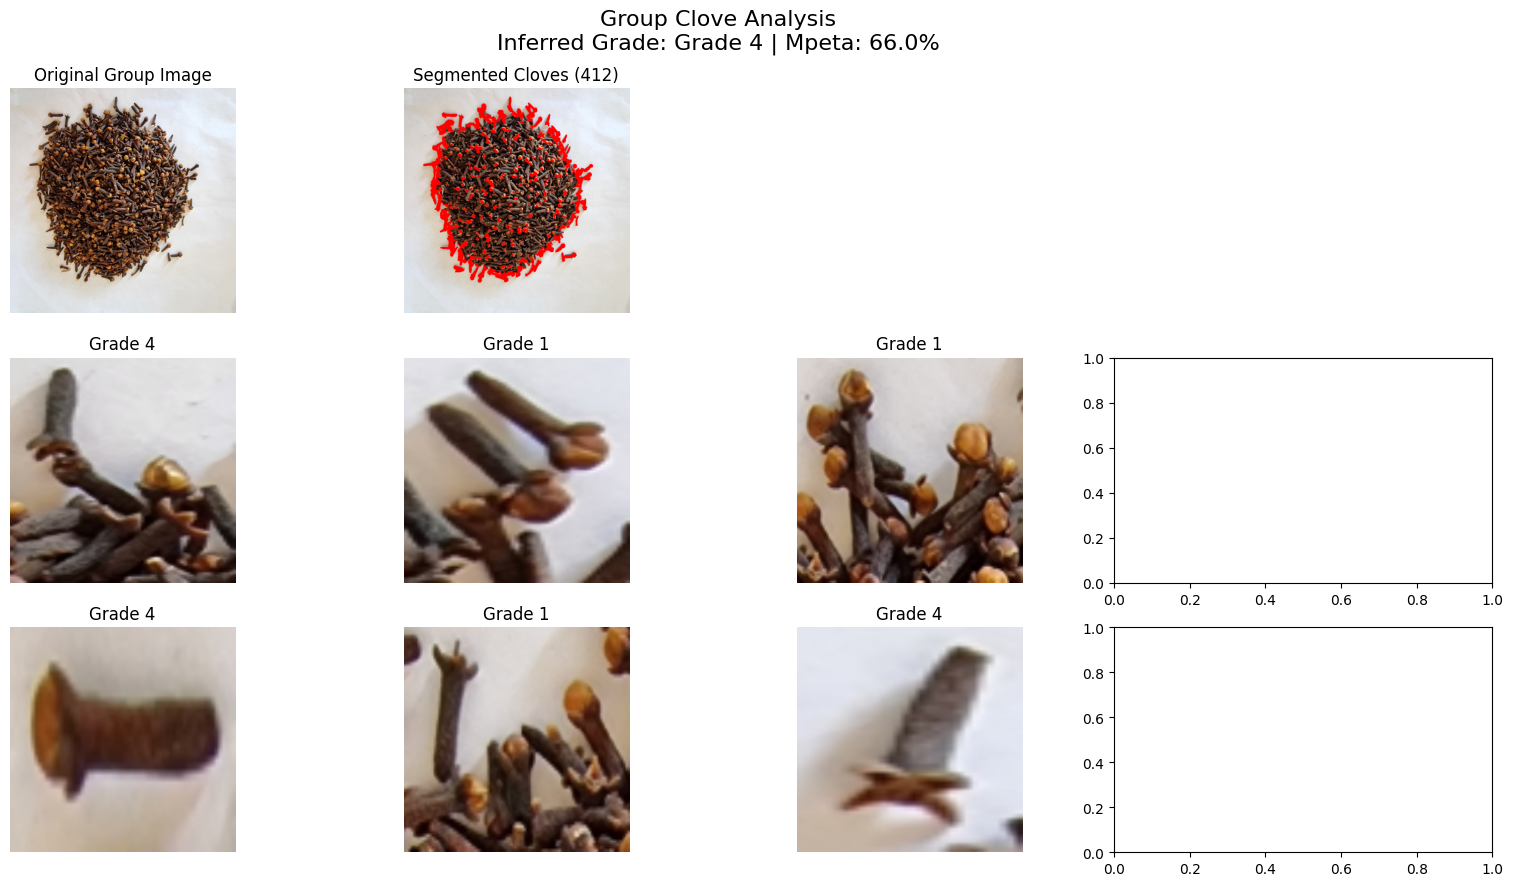


📝 AUDIT TRAIL SUMMARY:
------------------------------
  Grade 1: 140 cloves (34.0%)
  Grade 2: 0 cloves (0.0%)
  Grade 3: 0 cloves (0.0%)
  Grade 4: 272 cloves (66.0%)

🎯 Conclusion: Batch complies with **Grade 4** per ZSTC Mpeta threshold.
🔍 Analyzing group image: /kaggle/input/znz-cloves/group_photos/grade2/20250821_105052.jpg
✅ Resized image to 800x800 for memory-efficient processing
✅ Detected 296 individual cloves

📋 OFFICIAL GRADING RULES CHECK:
--------------------------------------------------
Total cloves detected: 296
Mpeta (Grade 4) count: 203 (68.6%)

✅ INFERRED BATCH GRADE: Grade 4
📘 Rule justification:
   • Max allowed Mpeta: ≤100%
   • Observed Mpeta: 68.6% → ✅ Compliant
   • Expected color: fermented (khoker)
   • May contain headless cloves (allowed in Grade 3+)


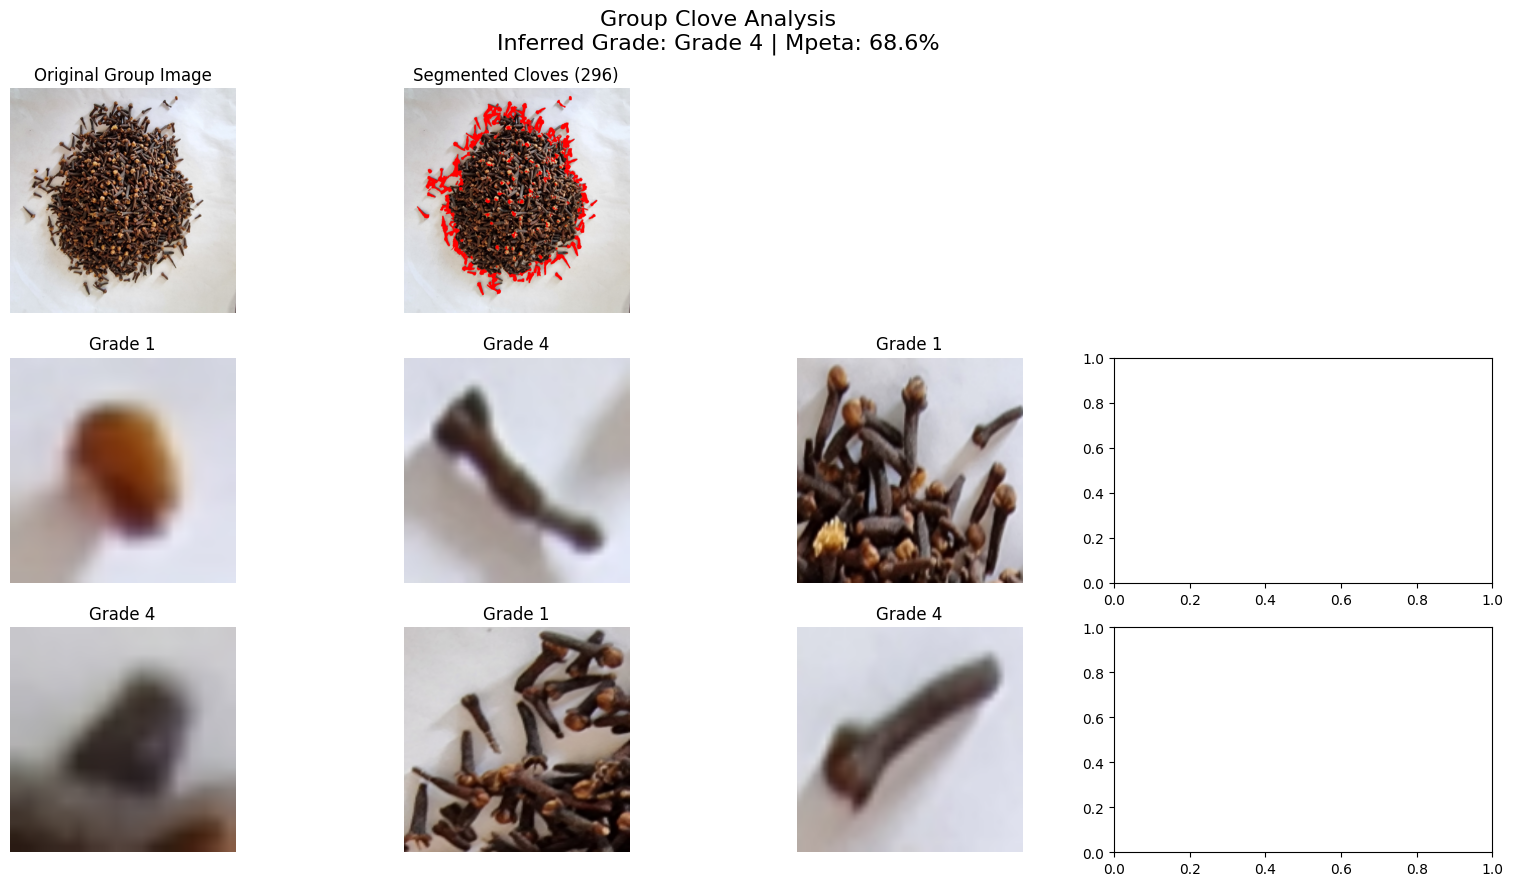


📝 AUDIT TRAIL SUMMARY:
------------------------------
  Grade 1: 93 cloves (31.4%)
  Grade 2: 0 cloves (0.0%)
  Grade 3: 0 cloves (0.0%)
  Grade 4: 203 cloves (68.6%)

🎯 Conclusion: Batch complies with **Grade 4** per ZSTC Mpeta threshold.
🔍 Analyzing group image: /kaggle/input/znz-cloves/group_photos/grade3/20250822_111823.jpg
✅ Resized image to 800x800 for memory-efficient processing
✅ Detected 319 individual cloves

📋 OFFICIAL GRADING RULES CHECK:
--------------------------------------------------
Total cloves detected: 319
Mpeta (Grade 4) count: 289 (90.6%)

✅ INFERRED BATCH GRADE: Grade 4
📘 Rule justification:
   • Max allowed Mpeta: ≤100%
   • Observed Mpeta: 90.6% → ✅ Compliant
   • Expected color: fermented (khoker)
   • May contain headless cloves (allowed in Grade 3+)


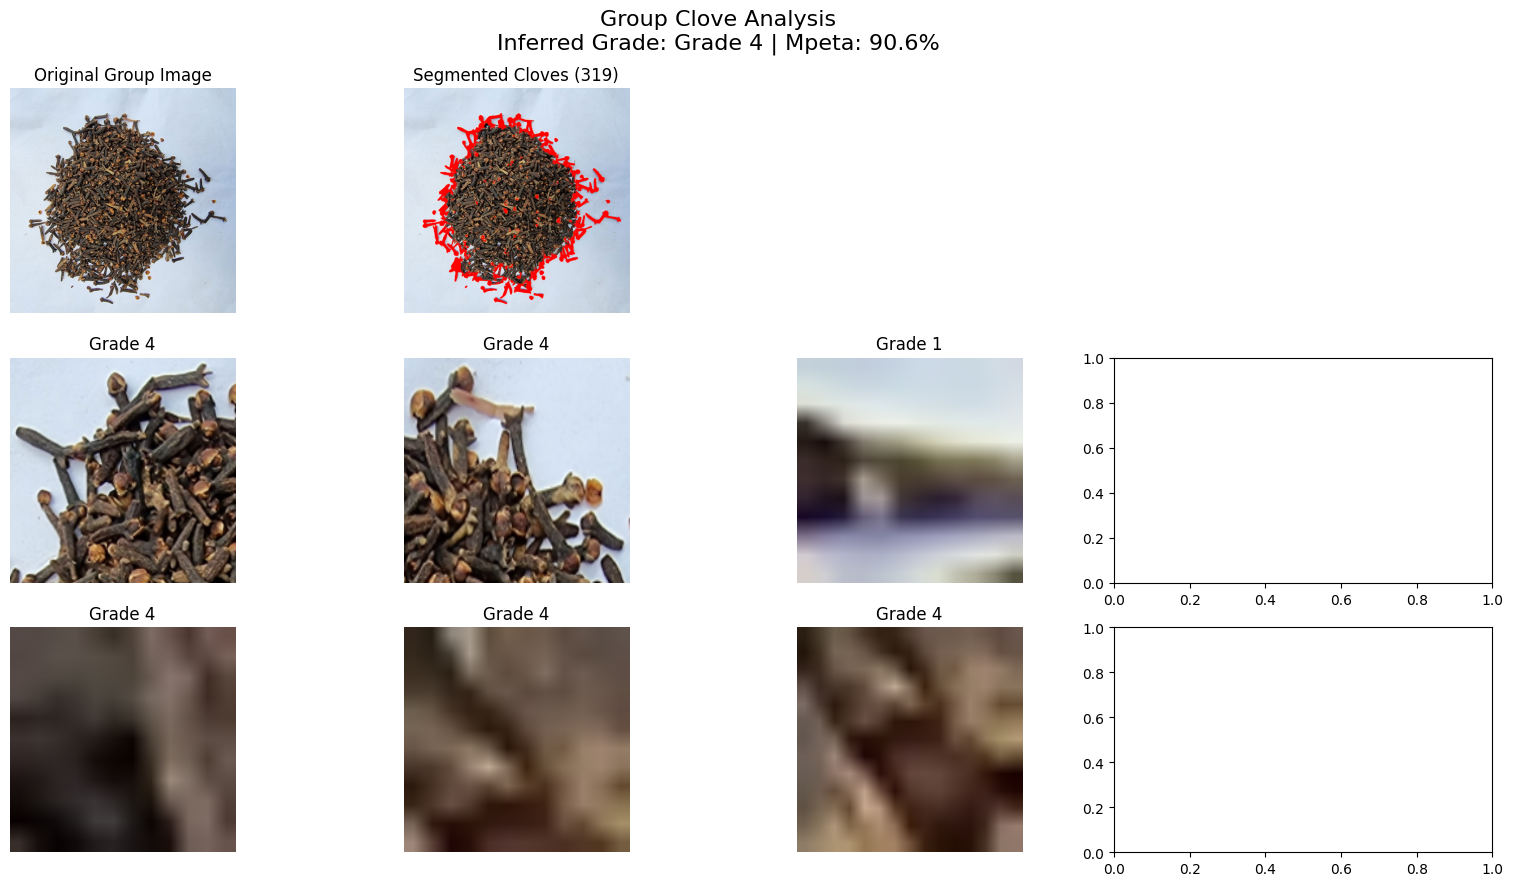


📝 AUDIT TRAIL SUMMARY:
------------------------------
  Grade 1: 30 cloves (9.4%)
  Grade 2: 0 cloves (0.0%)
  Grade 3: 0 cloves (0.0%)
  Grade 4: 289 cloves (90.6%)

🎯 Conclusion: Batch complies with **Grade 4** per ZSTC Mpeta threshold.
🔍 Analyzing group image: /kaggle/input/znz-cloves/group_photos/grade4/20250820_100336.jpg
✅ Resized image to 800x800 for memory-efficient processing
✅ Detected 451 individual cloves

📋 OFFICIAL GRADING RULES CHECK:
--------------------------------------------------
Total cloves detected: 451
Mpeta (Grade 4) count: 179 (39.7%)

✅ INFERRED BATCH GRADE: Grade 4
📘 Rule justification:
   • Max allowed Mpeta: ≤100%
   • Observed Mpeta: 39.7% → ✅ Compliant
   • Expected color: fermented (khoker)
   • May contain headless cloves (allowed in Grade 3+)


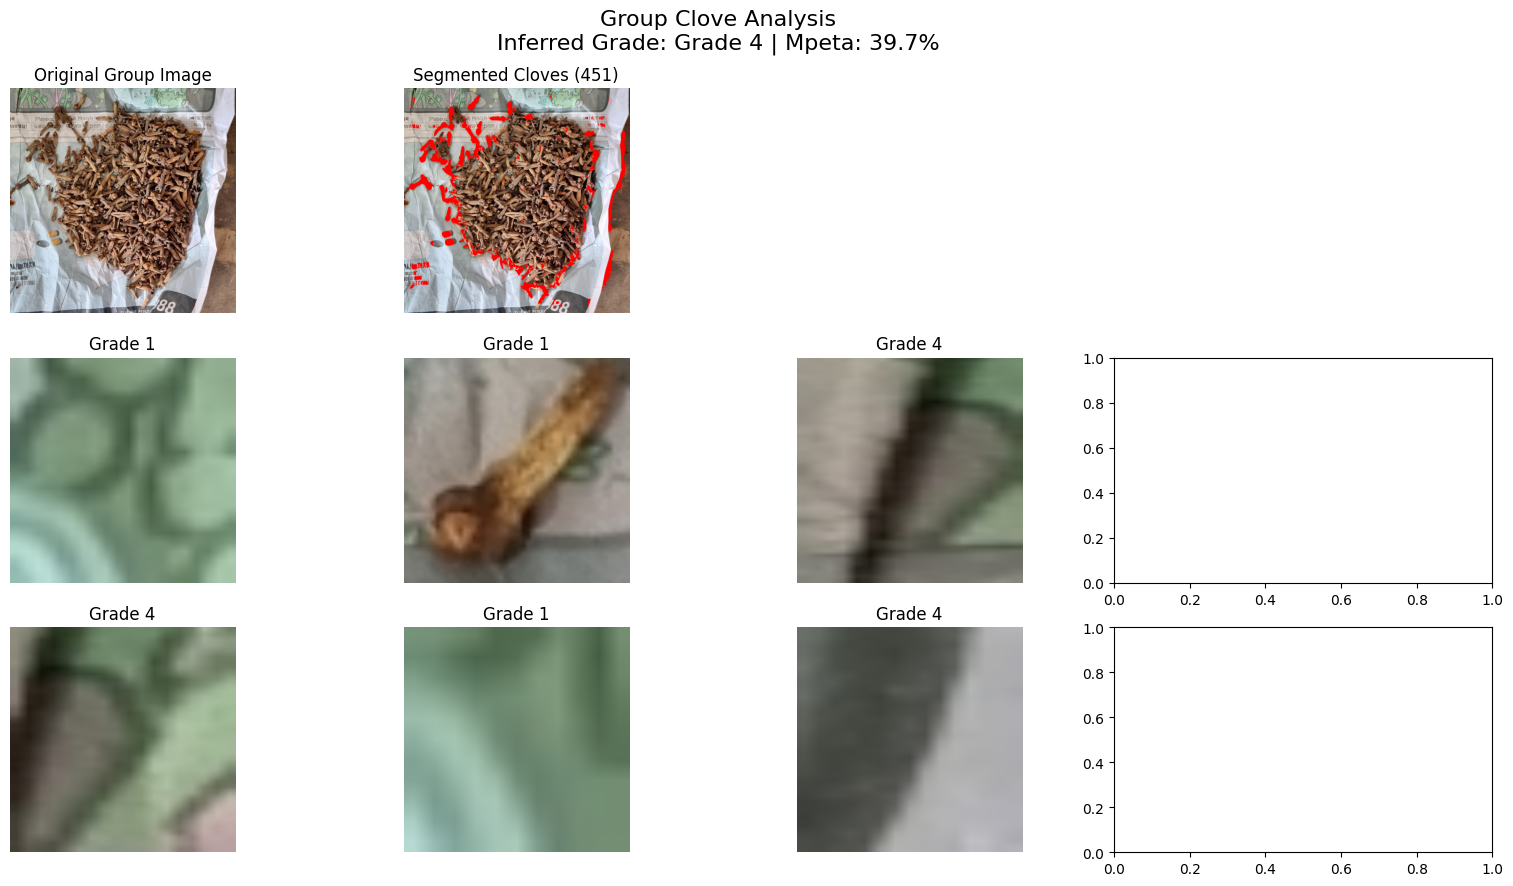


📝 AUDIT TRAIL SUMMARY:
------------------------------
  Grade 1: 272 cloves (60.3%)
  Grade 2: 0 cloves (0.0%)
  Grade 3: 0 cloves (0.0%)
  Grade 4: 179 cloves (39.7%)

🎯 Conclusion: Batch complies with **Grade 4** per ZSTC Mpeta threshold.
✅ Results saved to /kaggle/working/analysis_results.txt


In [2]:
# Save results to file
results_file = '/kaggle/working/analysis_results.txt'

with open(results_file, 'w') as f:
    f.write("🔍 GROUP CLOVE ANALYSIS RESULTS\n")
    f.write("=" * 80 + "\n")

all_results = []

for img_path in group_photos:
    print("="*80)
    result = analyze_group_image(img_path)
    all_results.append(result)
    print("="*80)

# Write summary to file
with open(results_file, 'a') as f:  # 'a' = append
    f.write("\n\n📊 FINAL SUMMARY:\n")
    f.write("-" * 50 + "\n")
    for i, res in enumerate(all_results):
        f.write(f"\n📌 Image {i+1}: {res['image_path']}\n")
        f.write(f"   • Detected cloves: {res['total_cloves']}\n")
        f.write(f"   • Grade 1: {res['grade_counts'][0]}\n")
        f.write(f"   • Grade 2: {res['grade_counts'][1]}\n")
        f.write(f"   • Grade 3: {res['grade_counts'][2]}\n")
        f.write(f"   • Grade 4: {res['grade_counts'][3]}\n")
        f.write(f"   • Mpeta %: {res['mpeta_pct']:.1f}%\n")
        f.write(f"   • Inferred Grade: {res['inferred_grade']}\n")

print(f"✅ Results saved to {results_file}")